# Packages

In [1]:
from sympy.logic.boolalg import to_cnf
from sympy.abc import A, B, C, D, E, F, G, H, J
import itertools
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
%%capture
!pip install python-sat

In [3]:
from pysat.examples.fm import FM
from pysat.formula import WCNF
from itertools import combinations
import math

In [7]:
class Model:
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
        self.wcnf_form = WCNF()
        self.FuMalik = None

        self.weights_solution = None

    def compute_solution(self):
        self.FuMalik = FM(self.wcnf_form, verbose = 10)
        self.FuMalik.compute()

        self.weights_solution = self.FuMalik.model[:self.n_neurons]
        self.weights_solution = [val > 0 for val in self.weights_solution]  # Bool vector

    def append_positive_clause(self, data, target_index):
        # print(f'Encoding for y True')
        for positive_clause in data.positive_clauses:
            # if (1, -2) clause --> [(w[0] V ~x[i][0]) V (~w[1] V x[i][1])] clause
            clause_to_add = []
            for index in positive_clause:
                abs_index = abs(index)
                prop_weight = data.prop_weights[abs_index - 1]  # variable, where weight is encoded
                prop_feature = data.prop_features[target_index][abs_index - 1]  # feature, that is encoded

                if index < 0:
                    clause_to_add.extend([int(-prop_weight), int(prop_feature)])
                else:
                    clause_to_add.extend([int(prop_weight), int(-prop_feature)])
            # print(f'Clause: {clause_to_add}')
            self.wcnf_form.append(clause_to_add, weight = 1)

    def calc_update(self, letters, x, w):
        # ['~', 'x', '2']
        x_or_w = ''
        to_put_minus = 1

        if letters[0] == '~':
            x_or_w = letters[1]
            to_put_minus = -1
        else:
            x_or_w = letters[0]
            to_put_minus = 1
        
        index = int(letters[-1])
        if x_or_w == 'x':
            return int(to_put_minus * x[index - 1])
            
        if x_or_w == 'w':
            return int(to_put_minus * w[index - 1])

    def append_negative_clause(self, data, target_index):
        # print(f'Encoding for negative y')
        for negative_clause in data.negative_clauses:
            # ('w 1', 'x 1', '~ w 2', '~ x 2')

            clause_to_add = []
            for symbol in negative_clause:
                # symbol is a string, like "w 1" or "~ x 2"
                letters = symbol.split(' ')
                clause_to_add.append(int(self.calc_update(letters, data.prop_features[target_index], data.prop_weights)))
            
            # print(f'Clause: {clause_to_add}')
            self.wcnf_form.append(clause_to_add, weight = 1)


    def encode_soft_clauses(self, data):
        Y_train = data.Y_train

        for i in range(len(Y_train)):
    
            y_i = Y_train[i]

            if y_i == True:
                self.append_positive_clause(data, target_index = i)

            if y_i == False:
                self.append_negative_clause(data, target_index = i)
            
    def encode_hard_clauses(self, data):
        for i in range(len(data.X_train)):
            for j in range(len(data.X_train[0])):
                
                if data.X_train[i][j] == True:
                    self.wcnf_form.append([int(data.prop_features[i][j])])
                else:
                    self.wcnf_form.append([int(-data.prop_features[i][j])])

    def calc_accuracy(self, X, Y):
        int_weights = np.array(self.weights_solution, dtype = 'int')

        pred = np.sign(np.dot(X, int_weights))
        return accuracy_score(Y, pred)

    def calc_metrics(self, X, Y):

        acc = self.calc_accuracy(
            np.array(X, dtype = 'int'),
            np.array(Y, dtype = 'int')
        )
        print(f'Accuracy: {acc}')
        
class DataProperties:
    def __init__(self, n_features, n_samples, train_percentage):
        self.n_features = n_features
        self.n_samples = n_samples
        self.train_percentage = train_percentage
        self.test_percentage = 1 - train_percentage
        
        self.n_train = int(self.train_percentage * self.n_samples)
        self.n_test = self.n_samples - self.n_train

        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        
        self.prop_features = None
        self.prop_weights = np.array([i + 1 for i in range(n_features)])

        self.features_combinations = None
        self.cartesian_products = None

        self.positive_clauses = []
        self.negative_clauses = []
    
    def encode_propositional_features(self):
        self.prop_features = np.array(
            [[i*self.n_features + j + max(self.prop_weights) + 1 for j in range(self.n_features)] for i in range(self.n_train)]
        )

    def prepare_dataset(self, func):
        np.random.seed(123)

        sample_arr = [True, False]
        

        self.X_train = np.random.choice(sample_arr, size = (self.n_train, self.n_features))
        self.X_test = np.random.choice(sample_arr, size = (self.n_test, self.n_features))

        self.Y_train = [func(x) for x in self.X_train]
        self.Y_test = [func(x) for x in self.X_test]


    def encode_features_combinations(self):

        majority_size = int(np.ceil(self.n_features / 2))
        assert(majority_size == np.floor(self.n_features / 2) + 1)
        self.features_combinations = list(combinations(self.prop_weights, majority_size))

    def remove_redundant(self, elements):
        res = []
        for e in elements:
            if not (e in res):
                res.append(e)
        return res

    def encode_cartesian_products(self):
        prods = list(itertools.product(*self.features_combinations))
        prods = [np.unique(combo).tolist() for combo in prods]
        self.cartesian_products = self.remove_redundant(prods)

    def prepare_predfinal_clauses(self):
        predfinal_clauses = []
        for product in self.cartesian_products:
            bracket = []
            for val in product:
                bracket.append([val, -val])
            predfinal_clauses.append(bracket)
        return predfinal_clauses


    def encode_positive_clauses(self):
        # Each element of optimized_products represents:
        # [1, 2] --> (w1 == x_i1) V (w2 == x_i2). But we have not transfered to CNF yet
        # To do that: [(~w1 V x_i1) & (w1 V ~x_i1)] V [(~w2 V x_i2) & (w2 V ~x_i2)]
        # which is 'encoded' as [[1, -1], [2, -2]]

        predfinal_clauses = self.prepare_predfinal_clauses()

        # And now we are creating final clauses
        for predfinal_clause in predfinal_clauses:
            clauses = list(itertools.product(*predfinal_clause))
            
            for clause in clauses:
                self.positive_clauses.append(clause)

    def encode_negative_clauses(self):

        ws_xs_list = []
        for combo in self.features_combinations:
            # print(combo)
            symbols = []
            for i in combo:
                symbols.extend([[f'w {i}', f'~ w {i}']])
                symbols.extend([[f'x {i}', f'~ x {i}']])
            ws_xs_list.append(symbols)
        
        for combination in ws_xs_list:
            for clause in itertools.product(*combination):
                # print(clause)
                self.negative_clauses.append(clause)


# Prepare indices

In [22]:
model = Model(n_neurons = 3)

data = DataProperties(
    n_features = model.n_neurons,
    n_samples = 60,
    train_percentage = 0.8  # test % = 100 - train %
)

## Encode propositional features

In [23]:
# define propositional variables for X
# propositional features cannot have same indices as w --> + 1 + max(w)
data.encode_propositional_features()

In [24]:
# Now prepare all cartesian products (for the case whey y == 1)
data.encode_features_combinations()
data.encode_cartesian_products()

## Encode clauses indices

In [25]:
data.encode_positive_clauses()
data.encode_negative_clauses()

# Preparing dataset

In [26]:
def check_2nd_feature(x):
    return x[1] == True

data.prepare_dataset(
    func = check_2nd_feature
)

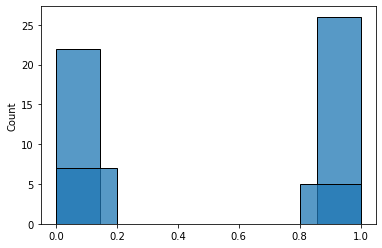

In [27]:
import seaborn as sns

sns.histplot(np.array(data.Y_train, dtype = 'int'))
sns.histplot(np.array(data.Y_test, dtype = 'int'))

# Encoding into clauses

In [28]:
model.encode_soft_clauses(data)
model.encode_hard_clauses(data)

# Compute solution

In [29]:
model.compute_solution()

c cost: 1; core sz: 4
c cost: 2; core sz: 4
c cost: 3; core sz: 4
c cost: 4; core sz: 4
c cost: 5; core sz: 4
c cost: 6; core sz: 4
c cost: 7; core sz: 4
c cost: 8; core sz: 4
c cost: 9; core sz: 4
c cost: 10; core sz: 4
c cost: 11; core sz: 4
c cost: 12; core sz: 4
c cost: 13; core sz: 5
c cost: 14; core sz: 6
c cost: 15; core sz: 5
c cost: 16; core sz: 6
c cost: 17; core sz: 5
c cost: 18; core sz: 4
c cost: 19; core sz: 5
c cost: 20; core sz: 4
c cost: 21; core sz: 4
c cost: 22; core sz: 6
c cost: 23; core sz: 7
c cost: 24; core sz: 5
c cost: 25; core sz: 5
c cost: 26; core sz: 4
c cost: 27; core sz: 5
c cost: 28; core sz: 5
c cost: 29; core sz: 4
c cost: 30; core sz: 4
c cost: 31; core sz: 9
c cost: 32; core sz: 6
c cost: 33; core sz: 4
c cost: 34; core sz: 4
c cost: 35; core sz: 4
c cost: 36; core sz: 4
c cost: 37; core sz: 4
c cost: 38; core sz: 4
c cost: 39; core sz: 4
c cost: 40; core sz: 4
c cost: 41; core sz: 4
c cost: 42; core sz: 4
c cost: 43; core sz: 4
c cost: 44; core sz:

# Checking the solution on the training data

In [30]:
model.calc_metrics(data.X_train, data.Y_train)

Accuracy: 0.8333333333333334


In [31]:
model.calc_metrics(data.X_test, data.Y_test)

Accuracy: 0.75
